In [ ]:
!pip install wget

# Techniques to Prevent Overfitting in Neural Networks

- Dropout
- Weight decay
- Early stopping

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import train_test_split

cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(cmap.N)]

mpl.rcParams["font.size"] = 24
mpl.rcParams["lines.linewidth"] = 2

## Load Dataset

In [ ]:
!python -m wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv \
    --output delaney-processed.csv

In [4]:
DELANEY_FILE = "delaney-processed.csv"
TASK_COL = 'measured log solubility in mols per litre'
df = pd.read_csv(DELANEY_FILE)
print(f"Number of molecules in the dataset: {df.shape[0]}")

Number of molecules in the dataset: 1128


In [5]:
X = df[[
        "Molecular Weight",
        "Number of H-Bond Donors",
        "Number of Rings",
        "Polar Surface Area"]].values
Y = df[TASK_COL].values.reshape(-1, 1) >= -2
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (1128, 4)
Shape of Y: (1128, 1)


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


## MLP Model

In [7]:
class MLPRegresion(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, norm=False, dropout=None):
        super(MLPRegresion, self).__init__()
        hidden_dim = [in_dim] + hidden_dim
        nn = []
        if norm:
            nn.append(torch.nn.BatchNorm1d(in_dim))

        for i in range(1, len(hidden_dim)):
            nn.append(torch.nn.Linear(hidden_dim[i-1], hidden_dim[i]))
            if dropout is not None:
                nn.append(torch.nn.Dropout(dropout))
            nn.append(torch.nn.ReLU())
        nn.append(torch.nn.Linear(hidden_dim[-1], out_dim))
        self.model = torch.nn.Sequential(*nn)


    def forward( self, x):
        for layer in self.model:
            x = layer(x)
        return x

## Training Utils

In [8]:
def train_one_epcoh(model, criterion, optimizer, dataloader):
    losses = []
    model.train()
    for x, y_true in dataloader:
        if device == "cuda":
            x, y_true = x.to(device), y_true.to(device)
        x, y_true = x.float(), y_true.float()
        optimizer.zero_grad()
        y_pred = model(x)
        y_pred = torch.sigmoid(y_pred)
        loss = criterion(y_pred, y_true.reshape(y_pred.shape))
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().detach().item())
    return losses


def val_one_epcoh(model, criterion, dataloader):
    losses = []
    model.eval()
    with torch.no_grad():
        for x, y_true in dataloader:
            if device == "cuda":
                x, y_true = x.to(device), y_true.to(device)
            x, y_true = x.float(), y_true.float()
            y_pred = model(x)
            y_pred = torch.sigmoid(y_pred)
            loss = criterion(y_pred, y_true.reshape(y_pred.shape))
            losses.append(loss.cpu().detach().item())
    return losses

In [9]:
def sample_dataloaders(batch_size=128):
    # training/validation dataset
    test_size = int(len(X)*0.3)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, shuffle=True)

    # create dataloaders
    X_train, X_test, y_train, y_test = map(torch.tensor, (X_train, X_test, y_train, y_test))

    train_data = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                            shuffle=True, drop_last=False)
    test_data = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                            shuffle=False, drop_last=False)
    return train_loader, test_loader

In [10]:
def run_one_fold(model, criterion, optimizer, train_loader, test_loader, n_epochs, early_stop=None):
    train_loss = []
    val_loss = []
    for epoch in range(n_epochs):
        losses = train_one_epcoh(model, criterion, optimizer, train_loader)
        train_loss.append(np.mean(losses))
        losses = val_one_epcoh(model, criterion, test_loader)
        val_loss.append(np.mean(losses))
        if early_stop is not None:
            early_stop(np.mean(losses), model)
            if early_stop.early_stop:
                print("Early stopping")
                break
    return train_loss, val_loss

In [11]:
def evaluate(model, test_loader):
    model.eval()
    truth = []
    preds = []
    with torch.no_grad():
        for x, y_true in test_loader:
            if device == "cuda":
                x, y_true = x.to(device), y_true.to(device)
            x, y_true = x.float(), y_true.float()
            truth.extend(y_true.cpu().detach().numpy().tolist())
            output = model(x)
            y_pred = torch.sigmoid(output).reshape(-1)
            y_pred = y_pred.cpu().detach().numpy()
            preds.extend(y_pred.tolist())
    return truth, preds

## Binary Classification Model to test teachniques to avoid overfitting

### Dropout, Ridge Regularization (weight decay)

In [12]:
n_splits = 3  # K-fold cross validation
n_epochs = 1500
batchzise = 32
hidden_dims = [512, 256, 256, 128, 128]
lr = 0.1
norm = True

## Feel free to tune hyperparameters below

# weight_decay = 1e-3
weight_decay = 0
# dropout = None
dropout = 0.5

Run cross validation.

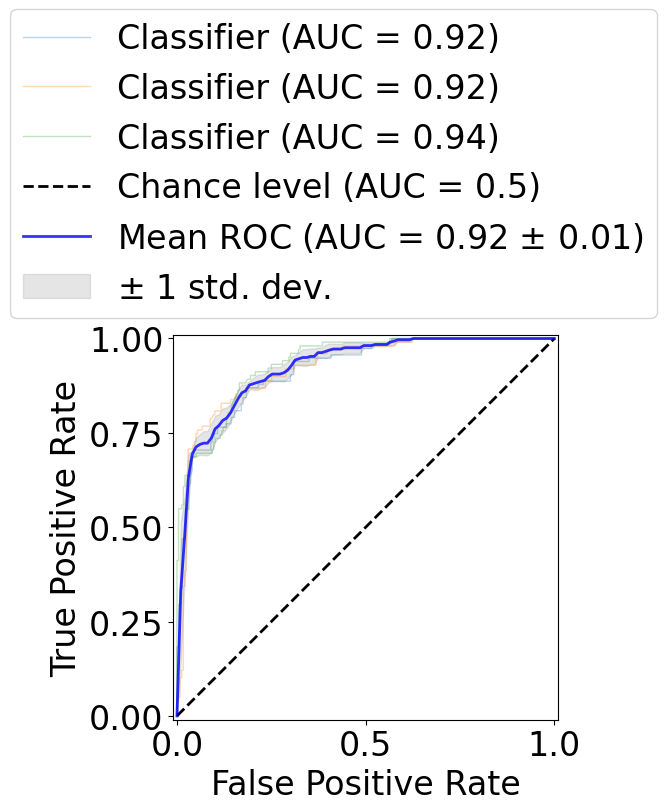

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

train_list = []
test_list = []

for fold in range(n_splits):
    # define model
    model = MLPRegresion(X.shape[1], hidden_dims, Y.shape[1], norm, dropout)
    model = model.to(device)
    model = model.float()
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    # train
    train_loader, test_loader = sample_dataloaders(batchzise)
    train_loss, val_loss = run_one_fold(model, criterion, optimizer,
                                        train_loader, test_loader, n_epochs)
    train_list.append(train_loss)
    test_list.append(val_loss)
    # evaluate
    y_test_true, y_test_pred = evaluate(model, test_loader)

    # record ROC curve
    viz = RocCurveDisplay.from_predictions(
        np.array(y_test_true),
        np.array(y_test_pred),
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits-1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# plot
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right", bbox_to_anchor=(1.3, 1))
plt.show()

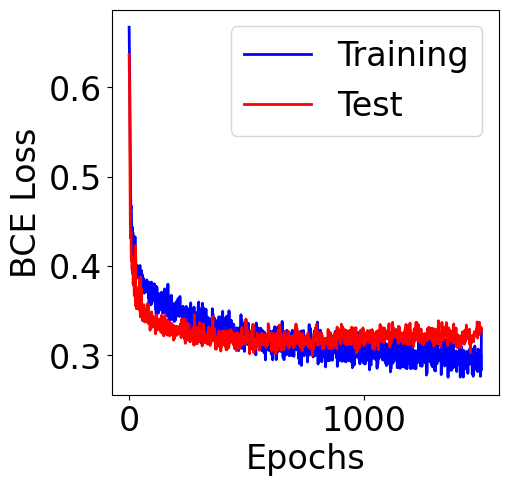

In [14]:
plt.figure(figsize=(5, 5))

train_mean = np.vstack([np.array(l).reshape(1, -1) for l in train_list]).mean(axis=0)
train_std = np.vstack([np.array(l).reshape(1, -1) for l in train_list]).std(axis=0)

plt.plot(range(n_epochs), train_mean, color="b", label="Training")
# plt.fill_between(range(n_epochs),
#                  train_mean-train_std, train_mean+train_std,
#                  alpha=0.5, color="b")

test_mean = np.vstack([np.array(l).reshape(1, -1) for l in test_list]).mean(axis=0)
test_std = np.vstack([np.array(l).reshape(1, -1) for l in test_list]).std(axis=0)
plt.plot(range(n_epochs), test_mean, color="red", label="Test")
# plt.fill_between(range(n_epochs),
#                  test_mean-test_std, test_mean+test_std,
#                  alpha=0.5, color="r")

plt.xlabel("Epochs")
plt.ylabel("BCE Loss")
plt.legend()

## Early Stopping
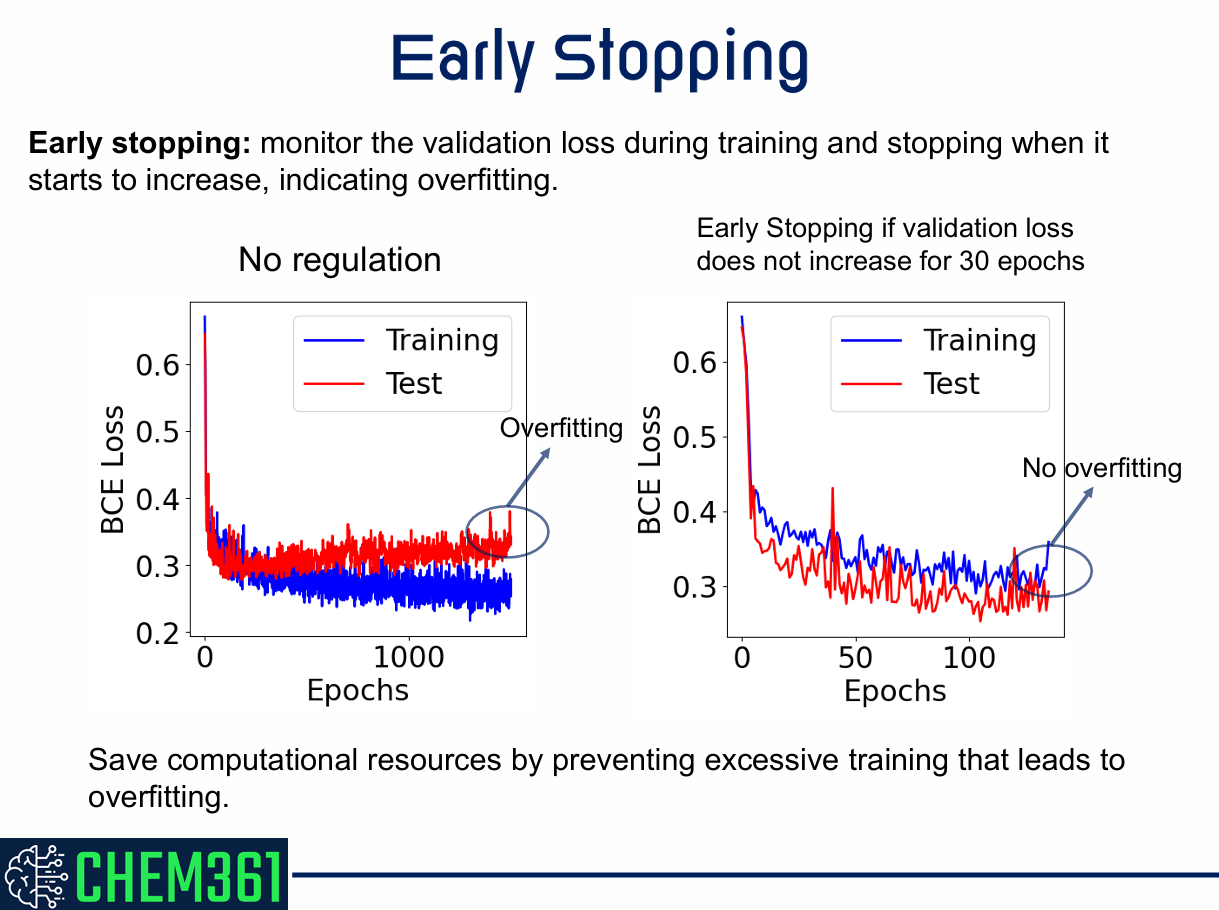

In [15]:
lr = 0.1
weight_decay = 0
dropout = None
norm = True

In [16]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, delta=1e-3, verbose=0):
        """
        Params
        ------
        patience : int
            steps/ epochs to wait after last time validation loss improved
        delta : float
            minimum change in the monitored quantity to qualify as an improvement
        path : str
            path to checkpoint params
        """
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.verbose = verbose
        self.scores = []

    def __call__(self, val_loss, model):
        score = -val_loss
        self.scores.append(score)
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose > 0:
              print(f'EarlyStopping counter: {self.counter} out of {self.patience}')

            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [17]:
patience = 30 # Early Stopping if validation loss does not increase for 30 epochs
delta = 1e-5

Run cross validation.

Early stopping
Early stopping
Early stopping


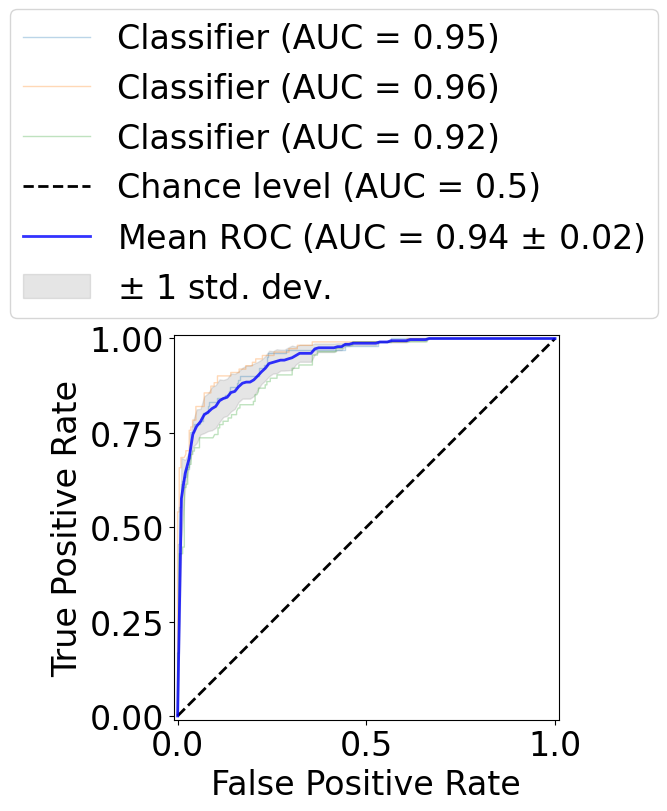

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

train_list = []
test_list = []

for fold in range(n_splits):
    early_stopping = EarlyStopping(patience=patience, delta=delta)
    # define model
    model = MLPRegresion(X.shape[1], hidden_dims, Y.shape[1], norm, dropout)
    model = model.to(device)
    model = model.float()
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    # train
    train_loader, test_loader = sample_dataloaders(batchzise)
    train_loss, val_loss = run_one_fold(model, criterion, optimizer,
                                        train_loader, test_loader, n_epochs, early_stopping)
    train_list.append(train_loss)
    test_list.append(val_loss)
    # evaluate
    y_test_true, y_test_pred = evaluate(model, test_loader)

    # record ROC curve
    viz = RocCurveDisplay.from_predictions(
        np.array(y_test_true),
        np.array(y_test_pred),
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits-1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

# plot
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend(loc="lower right", bbox_to_anchor=(1.3, 1))
plt.show()

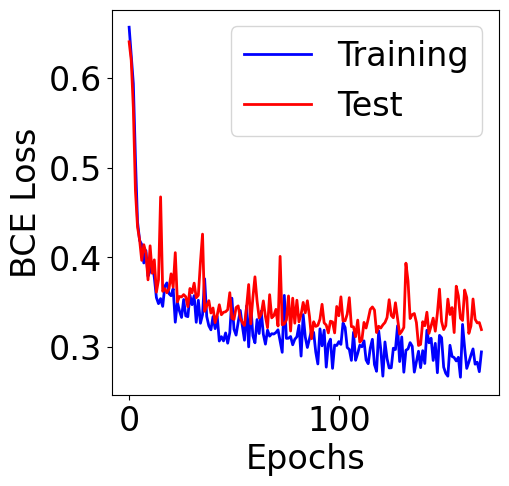

In [19]:
plt.figure(figsize=(5, 5))

plt.plot(train_loss, color="b", label="Training")
plt.plot(val_loss, color="red", label="Test")


plt.xlabel("Epochs")
plt.ylabel("BCE Loss")
plt.legend()